In [29]:
# Import packages
import os

import matplotlib.pyplot as plt
import numpy as np
import h5py
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

In [30]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

# Path to GRSM post-fire tile from October 2017 618mb
post_fire_path = os.path.join("ea-2022-capstone-project",
                              "data",
                              "neon-downloads",
                              "spectrometer-reflectance-mosaic",
                              "2017",
                              "NEON_D07_GRSM_DP3_274000_3947000_reflectance.h5")

# Path to GRSM pre-fire tile from June 2016 628mb
pre_fire_path = os.path.join("ea-2022-capstone-project",
                             "data",
                             "neon-downloads",
                             "spectrometer-reflectance-mosaic",
                             "2016",
                             "NEON_D07_GRSM_DP3_274000_3947000_reflectance.h5")



In [31]:
# Define functions used within notebook
def aop_h5refl2array(refl_filename):
    """Reads in a hdf5 file and returns an array and select metadata.
    
    This function is defined for the NEON AOP Reflectance hdf5 file 
    format. Adapted from the NEON Tutorial "Plot a Spectral Signature in
    Python - Tiled Data".
    
    Parameters
    ----------
    refl_filename : str
       Relative path of reflectance hdf5 file.
    
    Returns
    -------
    refl_array : h5py dataset
       Array of reflectance values.
    metadata : dict
       Dictionary containing the following metadata:
           epsg : coordinate reference system code as integer.
           *bad_band_window1 : numpy array of wavelengths to ignore.
           *bad_band_window2 : numpy array of wavelengths to ignore.
           extent : tuple of spatial extent (xmin, xmax, ymin, ymax).
           map_info : str of map information.
           *no_data_value : -9999.0
           projection : str of projection information.
           *res : dict containing 'pixel_width' and 'pixel_height'.
           *scale_factor : 10000.0
           shape : tuple of reflectance shape (y, x, number of bands).
           wavelength : h5py wavelengths dataset of the bands.
       * Asterixed values are the same for all NEON AOP hyperspectral 
       reflectance files processed 2016 & after.
    """
    # Read reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename, 'r')

    # Get site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    # Extract reflectance dataset
    refl = hdf5_file[sitename]['Reflectance']
    refl_array = refl['Reflectance_Data']
    refl_shape = refl_array.shape
    
    # Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = refl_array.shape
    metadata['wavelength'] = (
        refl['Metadata']['Spectral_Data']['Wavelength'])

    # Extract no data value & data scale factor
    metadata['no_data_value'] = float(
        refl_array.attrs['Data_Ignore_Value'])
    metadata['scale_factor'] = float(refl_array.attrs['Scale_Factor'])
    
    # Extract bad band windows
    metadata['bad_band_window1'] = (
        refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (
        refl.attrs['Band_Window_2_Nanometers'])
    
    # Extract projection information
    metadata['projection'] = (
        refl['Metadata']['Coordinate_System']['Proj4'][()])
    metadata['epsg'] = int(
        refl['Metadata']['Coordinate_System']['EPSG Code'][()])
    
    # Extract resolution from map information
    mapinfo = refl['Metadata']['Coordinate_System']['Map_Info'][()]
    mapinfo_string = str(mapinfo)
    mapinfo_split = mapinfo_string.split(",")
    metadata['res'] = {}
    metadata['res']['pixel_width'] = float(mapinfo_split[5])
    metadata['res']['pixel_height'] = float(mapinfo_split[6])
    
    # Extract the upper left-hand corner coordinates from map info
    xmin = float(mapinfo_split[3])
    ymax = float(mapinfo_split[4])
    
    # Calculate the xmax and ymin values from the dimensions
    xmax = xmin + (refl_shape[1] * metadata['res']['pixel_width']) 
    ymin = ymax - (refl_shape[0] * metadata['res']['pixel_height'])
    
    # Store the extent
    metadata['extent'] = (xmin, xmax, ymin, ymax)
    
    hdf5_file.close        
    return refl_array, metadata

def subset_clean_band(refl_array,metadata,band_number):
    """Extracts and cleans a reflectance band.
    
    The band is cleaned by applying the no data value and scale factor
    from the metadata dictionary. Adapted from the NEON Tutorial "Band
    Stacking, RGB & False Color Images, and Interactive Widgets in
    Python - Flightline Data".
    
    Parameters
    ----------
    refl_array: h5py dataset
       Reflectance array of dimensions (y,x,426) from which a band is 
       extracted.
    metadata: dict
       Reflectance metadata associated with reflectance array generated
       by aop_h5refl2array function.
    band_number: int
       Band number to be extracted (integer between 1-426).
    
    Returns 
    -------
    clean_band: numpy array
       Subsetted band array with no data value set to NaN and scale 
       factor applied.
    """
    clean_band = refl_array[:, :, band_number-1].astype(float)
    clean_band[clean_band==int(metadata['no_data_value'])]=np.nan
    clean_band = clean_band/metadata['scale_factor']
    
    return clean_band

def stack_subset_bands(refl_array, metadata, bands):
    """Subsets, cleans, and stacks bands from a reflectance array.
    
    Parameters
    ----------
    refl_array: h5py dataset
       Reflectance array of dimensions (y,x,426) from which multiple 
       bands (typically 3) are extracted.
    metadata: dict 
       Reflectance metadata associated with reflectance array generated
       by aop_h5refl2array function.
    bands: tuple
       Band numbers to be stacked (integer between 1-426).

    Returns 
    -------
    stacked_array: numpy array
       Array of subsetted, stacked bands with no data value set to NaN 
       and scale factor applied.
    """
    # Calculate rows and columns of the stacked array using the extent
    rows = int(metadata['extent'][3] - metadata['extent'][2])
    cols = int(metadata['extent'][1] - metadata['extent'][0])
    
    # Initialize stacked array with zeros
    # Took out int restriction to use float default for stack
    stacked_array = np.zeros((rows, cols, len(bands)))#, 'uint8')
    
    # Initialize band dictionary and names
    band_dict = {}
    band_names = []
    
    for i in range(len(bands)):
        band_names.append("b"+str(bands[i]))
        band_dict[band_names[i]] = subset_clean_band(
            refl_array, metadata, bands[i])
        # Not sure if we need to multiply by 256
        stacked_array[...,i] = band_dict[band_names[i]]#*256
                        
    return stacked_array

In [32]:
post_fire_refl, post_fire_metadata = aop_h5refl2array(post_fire_path)
pre_fire_refl, pre_fire_metadata = aop_h5refl2array(pre_fire_path)

In [33]:
print('Band 58 Center Wavelength = %.2f' %(
    post_fire_metadata['wavelength'][57]),'nm')
print('Band 84 Center Wavelength = %.2f' %(
    post_fire_metadata['wavelength'][83]),'nm')
print('Band 364 Center Wavelength = %.2f' %(
    post_fire_metadata['wavelength'][363]),'nm')

Band 58 Center Wavelength = 668.98 nm
Band 84 Center Wavelength = 799.19 nm
Band 364 Center Wavelength = 2201.40 nm


In [34]:
print('Band 58 Center Wavelength = %.2f' %(
    pre_fire_metadata['wavelength'][57]),'nm')
print('Band 84 Center Wavelength = %.2f' %(
    pre_fire_metadata['wavelength'][83]),'nm')
print('Band 364 Center Wavelength = %.2f' %(
    pre_fire_metadata['wavelength'][363]),'nm')

Band 58 Center Wavelength = 669.10 nm
Band 84 Center Wavelength = 799.30 nm
Band 364 Center Wavelength = 2201.46 nm


### We define:
* band 58 as the red band
* band 84 as the NIR band
* band 364 as the SWIR band

### We will subset and stack these bands in order of red, NIR, SWIR.

In [35]:
pre_fire_stack = stack_subset_bands(
    pre_fire_refl, pre_fire_metadata, (58, 84, 364))

In [37]:
post_fire_stack = stack_subset_bands(
    post_fire_refl, post_fire_metadata, (58, 84, 364))

## Vegetation Indices
### Normalized Burn Ratio (NBR)

In [38]:
# Calculate normalized burn ratio
post_fire_nbr = (
    post_fire_stack[:, :, 1] - post_fire_stack[:, :, 2]) / (
    post_fire_stack[:, :, 1] + post_fire_stack[:, :, 2])

pre_fire_nbr = (
    pre_fire_stack[:, :, 1] - pre_fire_stack[:, :, 2]) / (
    pre_fire_stack[:, :, 1] + pre_fire_stack[:, :, 2])

### Difference Normalized Burn Ratio (dNBR)
Calculate the difference between the pre-fire NBR and the post-fire NBR

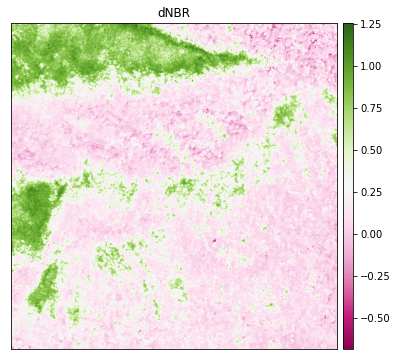

In [46]:
# Define difference normalized burn ratio
dnbr = pre_fire_nbr - post_fire_nbr

# Try earthpy plot dNBR
fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(dnbr,
              cmap='PiYG',
              #vmin=-1,
              #vmax=1,
              ax=ax,
              extent=post_fire_metadata['extent'],
              title="dNBR")

plt.show()

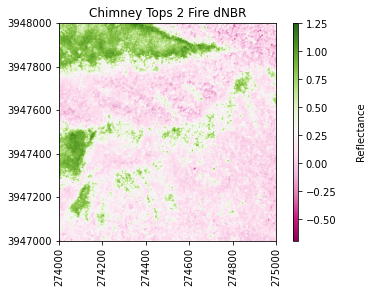

In [40]:
# Try NEON imshow plot dNBR
plot = plt.imshow(dnbr,
                  extent=post_fire_metadata['extent'])#,
                  #clim=(-0.5, 1))

cbar = plt.colorbar(plot, aspect=40); plt.set_cmap('PiYG');
cbar.set_label('Reflectance', rotation=90, labelpad=20)

plt.title('Chimney Tops 2 Fire dNBR'); ax = plt.gca();
ax.ticklabel_format(useOffset=False, style='plain');
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90);

### Normalized Difference Vegetation Index (NDVI)

In [42]:
# Calculate NDVI using earthpy.spatial normalized_diff function
post_fire_ndvi = es.normalized_diff(
    post_fire_stack[:,:,1], post_fire_stack[:,:,0])
pre_fire_ndvi = es.normalized_diff(
    pre_fire_stack[:,:,1], pre_fire_stack[:,:,0])

# Diff NDVI
diff_ndvi = pre_fire_ndvi - post_fire_ndvi

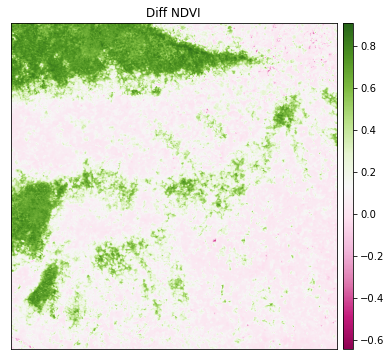

In [44]:
# Try earthpy plot diff NDVI
fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(diff_ndvi,
              cmap='PiYG',
              #vmin=-1,
              #vmax=1,
              ax=ax,
              extent=post_fire_metadata['extent'],
              title="Diff NDVI")

plt.show()

### Modified Soil Adjusted Vegetation Index (MSAVI)
* The modified soil adjusted vegetation index is a vegetation index in which the soil-noise background is minimized using a factor that varies inversely with the amount of vegetation present. 
* Qi, J., et. al. Remote Sens. Environ. 48, 119-126 (1994)
* The MSAVI equation has been expanded for ease of computation from its original form
$\frac{2NIR+1-\sqrt{(2NIR + 1)^{2}-8(NIR-Red)}}{2}$ to $NIR+0.5-0.5\sqrt{4NIR^{2}-4NIR+8Red+1}$

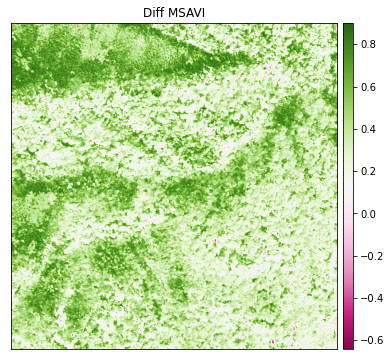

In [47]:
# Calculate MSAVI
pre_fire_msavi = pre_fire_stack[:,:,1] + 0.5 - 0.5 * (
    (4 * pre_fire_stack[:,:,1] * pre_fire_stack[:,:,1]) - (
     4 * pre_fire_stack[:,:,1]) + (
     8 * pre_fire_stack[:,:,0]) + 1)**(0.5)

post_fire_msavi = post_fire_stack[:,:,1] + 0.5 - 0.5 * (
    (4 * post_fire_stack[:,:,1] * post_fire_stack[:,:,1]) - (
     4 * post_fire_stack[:,:,1]) + (
     8 * post_fire_stack[:,:,0]) + 1)**(0.5)

diff_msavi = pre_fire_msavi - post_fire_msavi

# Try earthpy plot pre-fire MSAVI
fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(diff_msavi,
              cmap='PiYG',
              #vmin=-1,
              #vmax=1,
              ax=ax,
              extent=post_fire_metadata['extent'],
              title="Diff MSAVI")

plt.show()